Per-Protocol Model Summary:


model,lifelines.CoxPHFitter
duration col,'stop'
event col,'event'
weights col,'cum_weight_win'
entry col,'start'
robust variance,True
baseline estimation,breslow
number of observations,655.546
number of events observed,9.10279
partial log-likelihood,-29.05
time fit was run,2025-03-09 09:28:19 UTC



Intention-to-Treat Model Summary:


model,lifelines.CoxPHFitter
duration col,'stop'
event col,'event'
weights col,'cum_weight_win'
entry col,'start'
robust variance,True
baseline estimation,breslow
number of observations,663.896
number of events observed,9.16579
partial log-likelihood,-29.08
time fit was run,2025-03-09 09:28:19 UTC


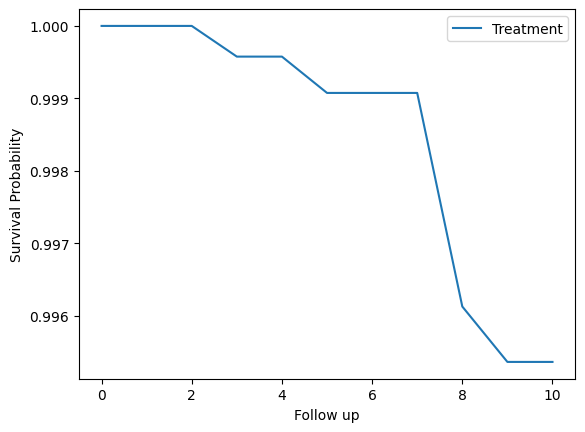

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('dataset/data_censored.csv')

# Function to compute weights and fit models for a given estimand
def process_estimand(data, estimand_type):
    if estimand_type == 'PP':
        # Treatment (switch) model only for PP
        eligible_data = data[data['eligible'] == 1].copy()
        
        # Numerator and denominator models for treatment
        numerator_model = smf.glm('treatment ~ age', eligible_data, 
                                 family=sm.families.Binomial()).fit()
        denominator_model = smf.glm('treatment ~ age + x1 + x3', eligible_data, 
                                   family=sm.families.Binomial()).fit()
        
        # Predict probabilities for treatment
        eligible_data['num_prob_tx'] = numerator_model.predict(eligible_data)
        eligible_data['denom_prob_tx'] = denominator_model.predict(eligible_data)
        
        # Compute treatment weights
        eligible_data['tx_num'] = np.where(eligible_data['treatment'] == 1,
                                          eligible_data['num_prob_tx'],
                                          1 - eligible_data['num_prob_tx'])
        eligible_data['tx_denom'] = np.where(eligible_data['treatment'] == 1,
                                            eligible_data['denom_prob_tx'],
                                            1 - eligible_data['denom_prob_tx'])
        eligible_data['sw_weight'] = eligible_data['tx_num'] / eligible_data['tx_denom']
        
        # Merge back to original data
        sw_weights = eligible_data[['id', 'period', 'sw_weight']]
        data_processed = pd.merge(data, sw_weights, on=['id', 'period'], how='left')
        data_processed.loc[:, 'sw_weight'] = data_processed['sw_weight'].fillna(1)
    else:
        data_processed = data.copy()
        data_processed['sw_weight'] = 1  # No treatment weighting for ITT
    
    # Censoring model
    numerator_formula = 'censored ~ x2'
    denominator_formula = 'censored ~ x2 + x1'
    
    censor_num_model = smf.glm(numerator_formula, data_processed,
                              family=sm.families.Binomial()).fit()
    censor_denom_model = smf.glm(denominator_formula, data_processed,
                                family=sm.families.Binomial()).fit()
    
    # Predict censoring probabilities
    data_processed['num_prob_censor'] = censor_num_model.predict(data_processed)
    data_processed['denom_prob_censor'] = censor_denom_model.predict(data_processed)
    
    # Compute censoring weights
    data_processed['cw_num'] = np.where(data_processed['censored'] == 1,
                                       data_processed['num_prob_censor'],
                                       1 - data_processed['num_prob_censor'])
    data_processed['cw_denom'] = np.where(data_processed['censored'] == 1,
                                         data_processed['denom_prob_censor'],
                                         1 - data_processed['denom_prob_censor'])
    data_processed['cw_weight'] = data_processed['cw_num'] / data_processed['cw_denom']
    
    # Compute cumulative weights
    data_sorted = data_processed.sort_values(['id', 'period'])
    data_sorted['cum_sw'] = data_sorted.groupby('id')['sw_weight'].cumprod()
    data_sorted['cum_cw'] = data_sorted.groupby('id')['cw_weight'].cumprod()
    data_sorted['cum_weight'] = data_sorted['cum_sw'] * data_sorted['cum_cw']
    
    # Filter out periods after censoring (make a copy to avoid chained assignment warnings)
    data_sorted['censored_ever'] = data_sorted.groupby('id')['censored'].cummax()
    data_filtered = data_sorted[data_sorted['censored_ever'] == 0].copy()
    
    # Winsorize weights at 99th percentile using .loc
    q99 = data_filtered['cum_weight'].quantile(0.99)
    data_filtered.loc[:, 'cum_weight_win'] = np.minimum(data_filtered['cum_weight'], q99)
    
    # Prepare for survival analysis using .loc for assignments
    data_filtered.loc[:, 'start'] = data_filtered['period']
    data_filtered.loc[:, 'stop'] = data_filtered['period'] + 1
    data_filtered.loc[:, 'event'] = data_filtered['outcome']
    
    return data_filtered

# Process PP and ITT estimands
pp_data = process_estimand(data, 'PP')
itt_data = process_estimand(data, 'ITT')

# Fit outcome models
# Fit outcome models
def fit_outcome_model(data, formula):
    cph = CoxPHFitter()
    cph.fit(data, duration_col='stop', event_col='event', entry_col='start',
            weights_col='cum_weight_win', formula=formula, robust=True)
    return cph

# PP model: treatment only
cph_pp = fit_outcome_model(pp_data, 'treatment')
# ITT model: treatment + x2
cph_itt = fit_outcome_model(itt_data, 'treatment + x2')

# Model summaries
print("Per-Protocol Model Summary:")
cph_pp.print_summary()
print("\nIntention-to-Treat Model Summary:")
cph_itt.print_summary()


# Predict survival probabilities (example for ITT)
# Using data from period 1
newdata = itt_data[itt_data['period'] == 1].copy()
newdata = newdata.drop(columns=['start', 'stop', 'event']).iloc[:1]  # Example row

# Predict survival function
pred_times = np.arange(0, 11)
surv = cph_itt.predict_survival_function(newdata, times=pred_times)

# Plot survival difference (example)
plt.figure()
plt.plot(surv.index, surv.iloc[:, 0], label='Treatment')
plt.xlabel('Follow up')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()
